## 3. Fitting an LSTM to the Wilding chord dataset

Despite the chord embeddings not looking too promising, we'll use them as the featurization layer for an LSTM.

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Embedding, Dense, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

We'll define a vectorizer that will make it easier to vectorize raw chord inputs.

In [3]:
class ChordVectorizer():
    def __init__(self, vectors='vectors.tsv', metadata='metadata.tsv'):
        vectors = open(vectors, 'r').read().split('\n')
        self.vectors = np.array([np.array([float(x) for x in vector.split('\t')]) for vector in vectors if vector])
        metadata = open(metadata, 'r').read().split('\n')
        self.metadata = [label for label in metadata if label]
        self.mapping = {k:v for k, v in zip(self.metadata, self.vectors)}
        
    def __call__(self, sequence):
        return np.array([self.tokenize_one(item) for item in sequence])
        
    def tokenize_one(self, item):
        return self.mapping[item] if item in self.mapping else self.mapping['[UNK]']
    
    def encode_one(self, item):
        return self.metadata.index(item) if item in self.metadata else 0
    
    def encode(self, sequence):
        return np.array([self.encode_one(item) for item in sequence])
    
    def decode_one(self, item):
        return self.metadata[item]

In [4]:
corpus = open('chords.txt', 'r').read()

In [5]:
progressions = corpus.split('\n')
progressions = [progression.split() for progression in progressions]

In [6]:
cv = ChordVectorizer(vectors='embeddings/wilding-w2v/embedding.tsv', metadata='embeddings/wilding-w2v/vocab.tsv')

In [7]:
progressions_vectorized = [cv(progression) for progression in progressions]

Let's print out the shape of the first chord progression. It's a sequence of 70 chords, each with an embedding of 128 dimensions.

In [26]:
progressions_vectorized[0].shape

(70, 128)

In [27]:
def onehot(x, shape):
    res = np.zeros(shape, dtype=np.uint8)
    res[x] = 1
    return res

This function will create vectors of contexts (preceding chord embeddings) and targets (the target chord that follows them). We'll choose a context length of 5.

In [31]:
def create_context_target_pairs(progressions, chord_vectorizer, context_length=5):
    progressions_vectorized = [chord_vectorizer(progression) for progression in progressions]
    vocab_size = len(chord_vectorizer.mapping)
    contexts = []
    targets = []
    for p_v, p in zip(progressions_vectorized, progressions):
        for i in range(len(p)):
            target = chord_vectorizer.encode_one(p[i])
            context = p_v[max(0, i - context_length):i]
            context_np = np.zeros((context_length, 128))
            context_np[5-len(context):] = context
            contexts.append(context_np)
            targets.append(onehot(target, vocab_size))
    return np.array(contexts), np.array(targets)

In [32]:
contexts, targets = create_context_target_pairs(progressions, cv)

In [33]:
contexts.shape

(3084, 5, 128)

## Define LSTM model

We'll define a minimal stacked LSTM with two LSTM layers, dropout, and no feed-forward layers. This will serve as a baseline and be faster to train and iterate.

In [34]:
def defineModel(input_shape, vocab_size):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(vocab_size, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
model = defineModel(input_shape=contexts[0].shape, vocab_size=len(cv.mapping))

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 128)            131584    
                                                                 
 dropout_2 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 101)               6565      
                                                                 
Total params: 187,557
Trainable params: 187,557
Non-trainable params: 0
_________________________________________________________________


We'll stop early if the validation loss hasn't increased in 5 epochs.

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [38]:
history = model.fit(x=contexts, y=targets, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

Epoch 1/50
87/87 [==============================] - 5s 24ms/step - loss: 3.8963 - accuracy: 0.0872 - val_loss: 3.7242 - val_accuracy: 0.1262
Epoch 2/50
87/87 [==============================] - 1s 13ms/step - loss: 3.4920 - accuracy: 0.1240 - val_loss: 3.6660 - val_accuracy: 0.1489
Epoch 3/50
87/87 [==============================] - 2s 21ms/step - loss: 3.3567 - accuracy: 0.1654 - val_loss: 3.5329 - val_accuracy: 0.2524
Epoch 4/50
87/87 [==============================] - 2s 23ms/step - loss: 3.2115 - accuracy: 0.2097 - val_loss: 3.4079 - val_accuracy: 0.2557
Epoch 5/50
87/87 [==============================] - 2s 21ms/step - loss: 3.0943 - accuracy: 0.2375 - val_loss: 3.3612 - val_accuracy: 0.2524
Epoch 6/50
87/87 [==============================] - 2s 23ms/step - loss: 3.0066 - accuracy: 0.2605 - val_loss: 3.3301 - val_accuracy: 0.2621
Epoch 7/50
87/87 [==============================] - 2s 27ms/step - loss: 2.9066 - accuracy: 0.2735 - val_loss: 3.3515 - val_accuracy: 0.2816
Epoch 8/50
87

In [39]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

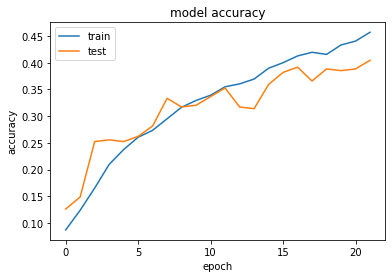

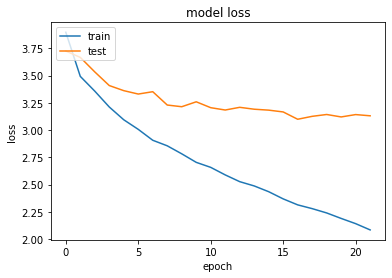

In [41]:
plot_history(history)

### Experiment with generation

Now we'll casually inspect whether the generated outputs match some of our intuition for chord progressions. We'll use an example input of `D7 G Em A7 D7`. The progression `Em A7 D7` strongly implies a circle of fifths progression, so we would expect the next chord to be `G7`, which is also the implied tonic in this chord progression.

In [53]:
example_input = 'D7 G Em A7 D7'.split()
vectorized = np.array([cv(example_input)])
cv.decode_one(np.argmax(model.predict(vectorized)))

'G7'

Great! Let's see what it predicts for the next chord in the sequence.

In [54]:
example_input = 'G Em A7 D7 G7'.split()
vectorized = np.array([cv(example_input)])
cv.decode_one(np.argmax(model.predict(vectorized)))

'C'

This makes sense as well, since `C` is the next chord in the circle of fifths.

So, this model seems to make reasonable predictions, which means that the word embeddings still likely learned something about the role of chords in a progression. However, it's limited in that it can only use the previous five chords to make a prediction. Also, the amount of data in the original dataset is laughably small.

Next, we'll switch to using a much larget MIDI dataset, and experiment with using GPT for chord generation!